***Importing important libraries required for OCR***

In [0]:
import cv2
import numpy as np
from skimage.filters import threshold_local
import imutils
import math
from scipy import ndimage

***Defining a function which map corner point of documents***

In [0]:
def rectify(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew

***Defining a function which crop the document according to rectify function***

In [0]:
def transformFourPoints(image, pts):

	rect = rectify(pts)
	(tl, tr, br, bl) = rect


	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))


	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))


	dst = np.array([[0, 0],	[maxWidth - 1, 0],	[maxWidth - 1, maxHeight - 1],	[0, maxHeight - 1]], dtype="float32")


	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped

***Load file in notebook***

In [82]:
from google.colab import files
uploaded = files.upload()

Saving pic_1.jpeg to pic_1 (2).jpeg


In [83]:
!ls

'pic_1 (1).jpeg'  'pic_1 (2).jpeg'   pic_1.jpeg   rotated.jpeg	 sample_data


In [0]:
for k, v in uploaded.items():
  open(k, 'wb').write(v)

***Reading images using openCV***

In [0]:
img = cv2.imread('pic_1.jpeg')

***Resizing images using OpenCV***

In [0]:
h, w, c = img.shape
factor = min(1, float(1024.0 /h))
height = int(h*factor)
width = int(w*factor)
dim = (width, height)
res = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)

***Desplaying resized images***

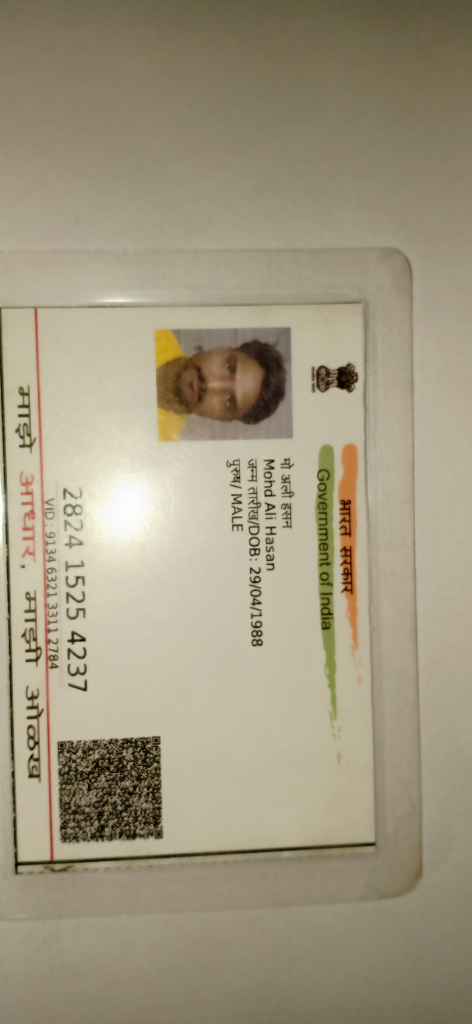

In [87]:
from google.colab.patches import cv2_imshow
cv2_imshow(res)

***Creating copy of resized image***

In [0]:
orig = res.copy()

***Converting to grayscale and blur to smooth***

In [0]:
gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

***Applying Canny for Edge Detection using Opencv***

***Applying Erode and Dilate to fill the gap of boundary and smooting***



In [0]:
edged = cv2.Canny(blurred, 0, 50)

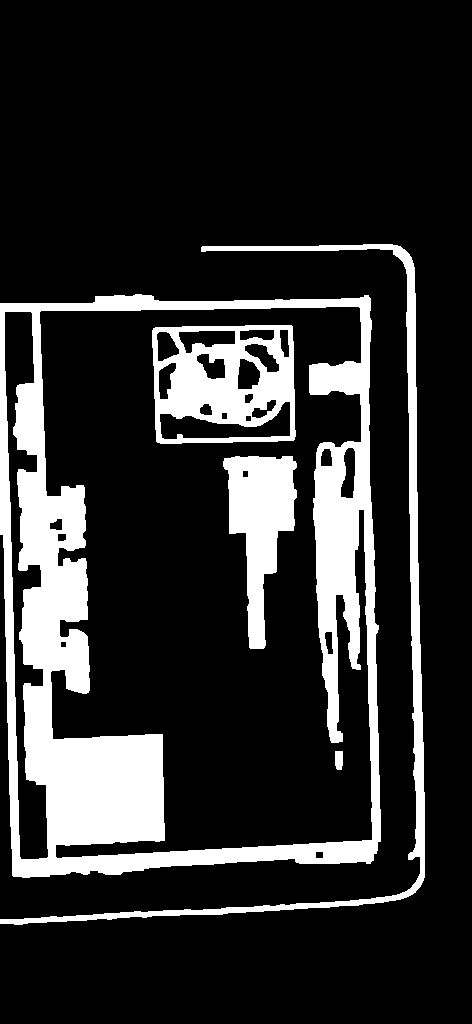

In [91]:
kernel = np.ones((5,5))
Dilate = cv2.dilate(edged, kernel, iterations = 2)
erode = cv2.erode(Dilate, kernel, iterations = 1)
cv2_imshow(erode)

***Finding the contours in the erode image, keeping only the largest ones, and initialize the screen contour***

In [0]:
(contours, _) = cv2.findContours(erode, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

***Get approximate contour***

In [0]:
for c in contours:
    p = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * p, True)
    if len(approx) == 4:
      target = approx
      break

***Drawing contour on blurred images and desplaying***

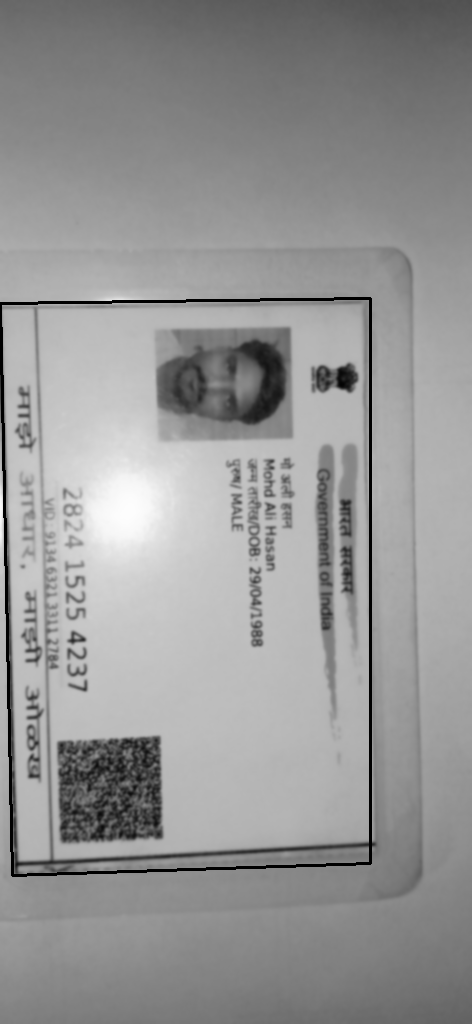

In [94]:
cv2.drawContours(blurred, [target], -1, (0, 255, 0), 2)
cv2_imshow(blurred)

***Cropping the images according to the contour and applying dynamic thresholding***

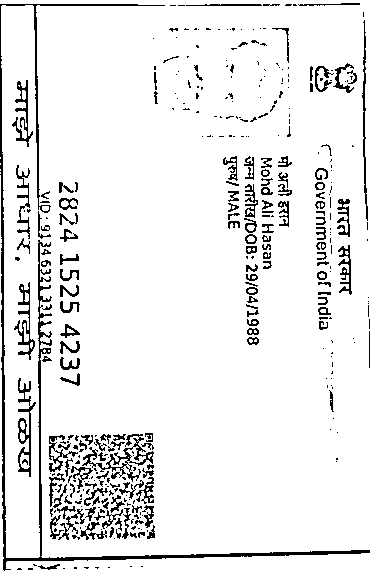

In [95]:
warped = transformFourPoints(gray, target.reshape(4, 2))

T = threshold_local(warped, 13, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

cv2_imshow(warped)

***Doing skew rotation for skewed image(if necessary)***

In [96]:
img_edges = cv2.Canny(warped, 100, 100, apertureSize=3)
lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

angles = []

for x1, y1, x2, y2 in lines[0]:
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)

median_angle = np.median(angles)
img_rotated = ndimage.rotate(warped, median_angle)

print("Angle is {}".format(median_angle))
cv2.imwrite('rotated.jpeg', img_rotated)

Angle is 88.8542371618249


True

***Desplaying rotated images***

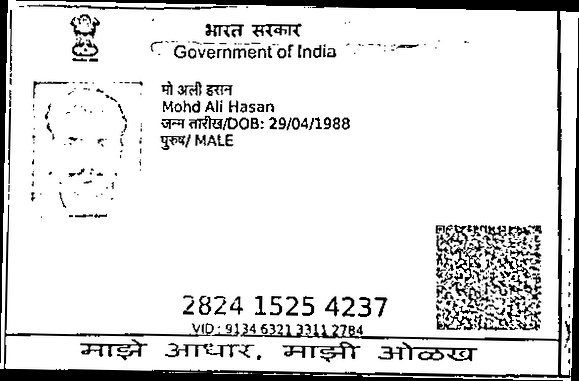

In [97]:
cv2_imshow(img_rotated)

***Creating boundary around images***

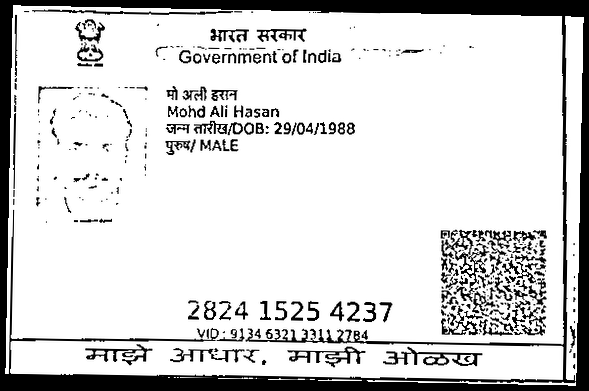

In [98]:
processed_image = cv2.copyMakeBorder(img_rotated, 5, 5, 5, 5, cv2.BORDER_CONSTANT)
cv2_imshow(processed_image)